In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')

In [3]:
import detectron2_1

In [4]:
from detectron2.config import get_cfg
from pathlib import Path
from detectron2.engine import DefaultPredictor
import cv2
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image
from detectron2.checkpoint import DetectionCheckpointer

## Get hard cases

In [2]:
def area_of(left_top, right_bottom):
    hw = np.clip(right_bottom - left_top, 0.0, None)
    return hw[0] * hw[1]

def iou_compute(boxes0, boxes1, eps=1e-5):
    overlap_left_top = np.maximum(boxes0[:2], boxes1[:2])
    overlap_right_bottom = np.minimum(boxes0[2:], boxes1[2:])

    overlap_area = area_of(overlap_left_top, overlap_right_bottom)
    area0 = area_of(boxes0[:2], boxes0[2:])
    area1 = area_of(boxes1[:2], boxes1[2:])
    return overlap_area / (area0 + area1 - overlap_area + eps)

def pred(predictor, im):
    outputs = predictor(im)
    instances = outputs['instances']
    pred_classes = instances.pred_classes  # tensor
    pred_boxes = instances.pred_boxes  # Boxes object
    pred_boxes = pred_boxes[pred_classes == 1].tensor
    scores = instances.scores  # tensor
    scores = scores[pred_classes == 1]

    return pred_boxes, scores


In [4]:

cfg_path = 'output/rcnn_2/config.yaml'
weights_path = 'output/rcnn_2/model_final.pth'
folder = '../phishpedia/benchmark/Sampled_phish1000'
conf_threshold = 0.05
iou_low_threshold = 0.5

cfg = get_cfg()
cfg.merge_from_file(cfg_path)
cfg.MODEL.WEIGHTS = weights_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = conf_threshold

# Initialize model
predictor = DefaultPredictor(cfg)

hard = []
hard_pred_boxes = []
hard_scores = []
for brand in os.listdir(folder):
    img_path = folder + '/' + brand + '/shot.png'
    im = cv2.imread(img_path)
    pred_boxes, scores = pred(predictor, im)

    print('For brand: ', brand)
    print('Predicted box: ', pred_boxes)

    ## get ground-truth box from annotation file
    lines = open('../phishpedia/benchmark/phish1000_coord.txt').readlines()
    for line in lines:
        line = line.strip()
        site = ','.join(line.split(',')[:-4])
        x1, y1, x2, y2 = list(map(lambda x: float(x), line.split(',')[-4:]))
        if site == brand:
            gt_bbox = np.array([x1, y1, x2, y2])
            break

    print('Ground-truth box: ', gt_bbox)

    ## compute iou for each pred_bbox
    max_iou = 0
    for pred_ in pred_boxes: 
        pred_ = pred_.detach().cpu().numpy()
        iou = iou_compute(pred_, gt_bbox)
        if iou > max_iou:
            max_iou = iou

    print(max_iou)

    if max_iou < iou_low_threshold: ## hard cases
        hard.append(brand)
        hard_pred_boxes.append(pred_boxes.detach().cpu())
        hard_scores.append(scores.detach().cpu())

    del pred_boxes, scores



For brand:  IRS+2020-05-18-11`25`38
Predicted box:  tensor([[110.7153,  27.9900, 265.5634,  90.9139]], device='cuda:0')
Ground-truth box:  [115.  29. 265.  92.]
0.9374689067357725
For brand:  AT&T Inc.+2020-05-29-12`51`42
Predicted box:  tensor([[  94.3781,   60.8293,  200.4830,  110.7024],
        [ 878.4846,  185.4051, 1037.5405,  222.6972],
        [  67.5641,   51.8139,  229.4689,  119.9458]], device='cuda:0')
Ground-truth box:  [ 94.  63. 200. 105.]
0.8357974416024477
For brand:  DGI (French Tax Authority)+2020-05-14-18`36`47
Predicted box:  tensor([[ 109.1224,   37.5095,  196.1336,   96.6428],
        [  99.4935,   26.5582,  500.5150,  100.5512],
        [1010.0828,   15.5798, 1229.4481,   58.6929],
        [1004.2850,   66.6426, 1238.6747,  113.0852],
        [ 220.8163,   35.7463,  501.0514,   75.7503],
        [1014.5806,   21.4887, 1043.6184,   52.8059]], device='cuda:0')
Ground-truth box:  [111.  36. 194.  97.]
0.9260164653769384
For brand:  ATB Financial+2020-05-18-10`59`46

For brand:  Apple Inc.+2020-05-04-12`26`19
Predicted box:  tensor([[225.4962,  59.6076, 321.6705,  91.4489],
        [188.8376,   5.4385, 212.3985,  33.5501],
        [579.2468, 238.9728, 792.7642, 302.8042],
        [339.9910, 853.1313, 998.4499, 958.9624]], device='cuda:0')
Ground-truth box:  [180.   7. 217.  38.]
0.5284251945911194
For brand:  Grupo Santander+2020-05-02-15`02`07
Predicted box:  tensor([[577.0880,   3.8175, 787.7094,  57.0435],
        [  6.0817,  77.5852,  84.3473, 150.7328],
        [582.2952,   2.9193, 632.9499,  51.4674]], device='cuda:0')
Ground-truth box:  [570.   5. 797.  61.]
0.8457243983968921
For brand:  TPG Telecom+2020-05-03-10`48`58
Predicted box:  tensor([[167.7704,  17.9644, 295.1315,  68.9279],
        [814.6099, 206.1782, 902.1318, 238.0914]], device='cuda:0')
Ground-truth box:  [169.  23. 289.  65.]
0.7764880414947778
For brand:  Google Inc.+2020-05-26-12`45`16
Predicted box:  tensor([[ 918.5532,  101.6380,  997.3751,  132.9663],
        [ 897.6555,

For brand:  Bank of America+2020-05-24-05`36`07
Predicted box:  tensor([[400.3804,  15.1914, 637.0870,  54.2091],
        [408.8907,  67.8057, 696.8959, 120.3435]], device='cuda:0')
Ground-truth box:  [389.   9. 641.  53.]
0.786827581556726
For brand:  Credit Agricole S.A.+2020-05-13-15`01`10
Predicted box:  tensor([[8.2310e-01, 8.4344e+00, 1.6893e+02, 5.5750e+01],
        [1.2976e+03, 0.0000e+00, 1.3638e+03, 6.2534e+01]], device='cuda:0')
Ground-truth box:  [  2.  15. 175.  55.]
0.8146187346991997
For brand:  AOL Inc.+2020-05-09-14`58`47
Predicted box:  tensor([[   8.8535,    7.8413,  121.4528,   60.4073],
        [ 959.1290,   96.2290, 1073.9072,  148.4207]], device='cuda:0')
Ground-truth box:  [ 13.   8. 121.  60.]
0.9488272345727303
For brand:  1&1 Ionos+2020-05-19-03`46`41
Predicted box:  tensor([[  45.5417,   30.1193,  103.0607,   85.2511],
        [  34.6101,  115.8164,  290.7296,  162.2448],
        [ 740.3893,  285.8365,  920.6290,  357.5871],
        [1112.5458,  202.0880, 13

For brand:  ING+2020-05-02-17`11`56
Predicted box:  tensor([[1026.8337,  277.6533, 1162.1809,  319.4864],
        [ 989.5479,  267.6608, 1169.5695,  332.1252]], device='cuda:0')
Ground-truth box:  [1025.  267. 1165.  322.]
0.7353246264511597
For brand:  Landesbank Berlin AG+2020-05-01-13`28`40
Predicted box:  tensor([[  25.0259,   13.2470,   99.4011,   50.2196],
        [  19.0359,    9.3723,  212.4113,   50.2423],
        [1232.6244,   43.0788, 1349.4478,  156.1063],
        [ 108.3348,   15.2734,  207.5331,   49.0285]], device='cuda:0')
Ground-truth box:  [ 26.  11. 213.  53.]
0.866521714388296
For brand:  Daum+2020-05-21-20`11`55
Predicted box:  tensor([[ 903.7900,   16.6775, 1018.7609,   73.1441]], device='cuda:0')
Ground-truth box:  [ 895.   20. 1030.   67.]
0.726940913572019
For brand:  Canadian Imperial Bank of Commerce+2020-05-02-15`57`16
Predicted box:  tensor([[651.7001,   3.1026, 713.0119,  55.6542],
        [628.2126,   0.0000, 733.8965,  63.2607]], device='cuda:0')
Ground-

For brand:  RBC Royal Bank+2020-05-01-15`11`13
Predicted box:  tensor([[187.2584,   6.6617, 243.6539,  65.0123],
        [186.3052,   2.9702, 415.1769,  66.3141]], device='cuda:0')
Ground-truth box:  [185.   1. 414.  63.]
0.9095864728550934
For brand:  Navy Federal Credit Union+2020-05-02-15`46`26
Predicted box:  tensor([[259.2653,  13.5321, 383.6617,  97.9808],
        [246.5173,   8.9682, 484.9713, 105.6667]], device='cuda:0')
Ground-truth box:  [251.   7. 489. 105.]
0.9395827710713929
For brand:  1&1 Ionos+2020-05-21-20`57`41
Predicted box:  tensor([[ 12.5842,   7.6489, 148.9234,  56.9894],
        [  8.8990,   4.2592, 241.3901,  62.2922]], device='cuda:0')
Ground-truth box:  [ 18.  11. 143.  49.]
0.7061056571227687
For brand:  Facebook, Inc.+2020-05-21-11`36`21
Predicted box:  tensor([[126.7991,  14.4359, 316.9316,  70.2700]], device='cuda:0')
Ground-truth box:  [136.  16. 314.  68.]
0.8719011084393495
For brand:  Wells Fargo & Company+2020-05-25-05`50`16
Predicted box:  tensor([[4

For brand:  Grupo Santander+2020-05-24-04`04`37
Predicted box:  tensor([[310.1194,  16.1100, 543.1975,  76.3109]], device='cuda:0')
Ground-truth box:  [316.  22. 545.  79.]
0.8368335948369122
For brand:  1&1 Ionos+2020-05-23-19`25`44
Predicted box:  tensor([[  8.0636,   8.9299, 152.8009,  59.5841]], device='cuda:0')
Ground-truth box:  [ 15.  16. 149.  51.]
0.6397001822905589
For brand:  M & T Bank Coporation+2020-05-13-11`33`47
Predicted box:  tensor([[610.7418,   5.4179, 752.1721,  45.4357]], device='cuda:0')
Ground-truth box:  [610.   3. 755.  49.]
0.8485355033326881
For brand:  Cox Communications+2020-05-19-04`36`52
Predicted box:  tensor([[302.1958,  46.5996, 373.2365,  77.1287]], device='cuda:0')
Ground-truth box:  [297.  43. 371.  79.]
0.7687833584066256
For brand:  RBC Royal Bank+2020-05-25-18`13`37
Predicted box:  tensor([[458.0636,   4.1492, 602.7695,  52.8284],
        [465.2293,   6.7249, 509.2480,  51.7137]], device='cuda:0')
Ground-truth box:  [465.   6. 601.  48.]
0.81088

For brand:  Spotify+2020-05-12-12`19`16
Predicted box:  tensor([[576.1988,  20.9046, 786.1724,  86.6191],
        [578.3010,  19.6007, 646.5261,  86.2673]], device='cuda:0')
Ground-truth box:  [578.  21. 791.  83.]
0.9155228726208309
For brand:  Universo Online+2020-05-24-07`23`48
Predicted box:  tensor([[ 454.9933,   18.0466,  657.9791,   73.7058],
        [1260.9680,  157.1023, 1350.6318,  186.2148],
        [ 199.1503,  127.1016,  575.9706,  538.5641]], device='cuda:0')
Ground-truth box:  [459.  22. 581.  75.]
0.5506416534359644
For brand:  ASB Bank Limited+2020-05-23-17`59`14
Predicted box:  tensor([[ 901.5162,   34.8476, 1023.1883,   81.4103]], device='cuda:0')
Ground-truth box:  [ 903.   38. 1023.   78.]
0.847252748882716
For brand:  DocuSign+2020-05-02-18`24`21
Predicted box:  tensor([[ 31.9777,  12.1489, 177.3122,  62.9337],
        [587.3606, 274.6367, 799.4191, 319.4844],
        [619.6294, 442.1208, 763.6625, 482.6562]], device='cuda:0')
Ground-truth box:  [ 32.  16. 182.  6

For brand:  Visa International Service Association+2020-05-09-13`31`43
Predicted box:  tensor([[ 795.2011,  130.0394, 1074.8588,  272.1592],
        [ 120.6001,   24.8849,  348.3948,   51.5536],
        [ 292.7250,  152.6880,  688.6210,  203.9028],
        [ 271.5947,  133.3646,  722.0994,  259.7104]], device='cuda:0')
Ground-truth box:  [ 857.  198. 1042.  267.]
0.321173295155392
For brand:  ATB Financial+2020-05-16-12`10`36
Predicted box:  tensor([[403.2036,  53.0500, 958.4402, 112.1527],
        [403.4390,  42.4357, 963.3982, 164.9379]], device='cuda:0')
Ground-truth box:  [682.  52. 797. 113.]
0.20575084313765285
For brand:  CenturyLink+2020-05-30-11`38`39
Predicted box:  tensor([[807.8026,  11.7720, 974.2991,  54.7795],
        [812.3802,  11.5719, 856.3889,  54.9571]], device='cuda:0')
Ground-truth box:  [811.   2. 970.  50.]
0.6974990883749749
For brand:  Spotify+2020-05-02-15`24`10
Predicted box:  tensor([[ 105.3442,   13.6962,  246.4836,   64.2918],
        [1117.8356,   13.68

For brand:  Facebook, Inc.+2020-05-30-10`16`44
Predicted box:  tensor([[ 903.9589,    4.6390, 1015.7404,   40.5304]], device='cuda:0')
Ground-truth box:  [ 895.   -2. 1020.   39.]
0.7252397353294958
For brand:  Bank of America+2020-05-11-15`11`05
Predicted box:  tensor([[118.5037,  13.4945, 359.7247,  52.2094],
        [123.5861,  85.5943, 418.4829, 155.5981]], device='cuda:0')
Ground-truth box:  [119.   4. 360.  61.]
0.6774845402061046
For brand:  Amazon.com Inc.+2020-05-08-00`05`23
Predicted box:  tensor([[625.4641,   4.5779, 743.1315,  47.6669]], device='cuda:0')
Ground-truth box:  [617.   2. 747.  43.]
0.7689944928331076
For brand:  Equa bank+2020-05-24-00`44`56
Predicted box:  tensor([[210.8171,   7.7594, 347.1664,  48.9519]], device='cuda:0')
Ground-truth box:  [207.   3. 348.  46.]
0.8064477803703771
For brand:  Webmail Providers+2020-05-09-12`25`53
Predicted box:  tensor([[530.3885, 125.5302, 839.2786, 195.3407]], device='cuda:0')
Ground-truth box:  [534. 123. 843. 189.]
0.8580

For brand:  Amazon.com Inc.+2020-05-26-13`51`59
Predicted box:  tensor([[ 902.1107,    5.3314, 1019.9830,   51.6811]], device='cuda:0')
Ground-truth box:  [ 899.    5. 1015.   38.]
0.6581583509683087
For brand:  DGI (French Tax Authority)+2020-05-14-18`37`20
Predicted box:  tensor([[ 109.1224,   37.5095,  196.1336,   96.6428],
        [  99.4935,   26.5582,  500.5150,  100.5512],
        [1010.0828,   15.5798, 1229.4481,   58.6929],
        [1004.2850,   66.6426, 1238.6747,  113.0852],
        [ 220.8163,   35.7463,  501.0514,   75.7503],
        [1014.5806,   21.4887, 1043.6184,   52.8059]], device='cuda:0')
Ground-truth box:  [111.  34. 199.  93.]
0.8416130520763018
For brand:  Amazon.com Inc.+2020-05-19-11`15`21
Predicted box:  tensor([[625.4725,   4.5751, 743.1302,  47.7220]], device='cuda:0')
Ground-truth box:  [626.   6. 740.  39.]
0.7410515609658597
For brand:  IRS+2020-05-15-10`39`00
Predicted box:  tensor([[111.4888,  27.8506, 264.3532,  91.5076],
        [120.9120, 560.6678, 

For brand:  RuneScape+2020-05-04-11`26`55
Predicted box:  tensor([[609.7780, 170.8649, 750.1389, 219.9377],
        [543.5679, 160.2555, 769.1774, 226.6999]], device='cuda:0')
Ground-truth box:  [612. 172. 756. 221.]
0.9044254445774612
For brand:  WeTransfer+2020-05-29-12`51`06
Predicted box:  tensor([[118.0385,  95.9703, 317.9131, 246.4612],
        [ 10.3206,  11.1263,  70.1973,  44.9224],
        [157.9913,  99.7100, 279.2544, 207.1111]], device='cuda:0')
Ground-truth box:  [ 8.  6. 73. 48.]
0.7412437344690216
For brand:  Chronopost International+2020-05-02-18`12`53
Predicted box:  tensor([[4.1468e-02, 2.7140e+01, 2.9777e+02, 1.0857e+02],
        [0.0000e+00, 3.3247e+01, 5.6909e+01, 1.0645e+02],
        [9.5606e+02, 6.7042e+02, 1.1170e+03, 7.1067e+02],
        [2.0666e+02, 6.6848e+02, 3.4869e+02, 7.1312e+02]], device='cuda:0')
Ground-truth box:  [  2.  32. 289.  92.]
0.710235689649823
For brand:  Dropbox, Inc.+2020-05-24-02`17`20
Predicted box:  tensor([[ 11.4056,  16.6772, 284.2505

For brand:  Steam+2020-05-22-22`19`23
Predicted box:  tensor([[481.7389,  20.3551, 640.5421,  76.4594]], device='cuda:0')
Ground-truth box:  [482.  25. 640.  82.]
0.8309272881953081
For brand:  Office365+2020-05-24-12`56`45
Predicted box:  tensor([], device='cuda:0', size=(0, 4))
Ground-truth box:  [480. 232. 564. 270.]
0
For brand:  PostFinance+2020-05-13-10`47`24
Predicted box:  tensor([[497.6874,  14.1346, 670.4437,  73.5612]], device='cuda:0')
Ground-truth box:  [502.  19. 664.  70.]
0.804767102217846
For brand:  AutoScout24+2020-05-27-16`53`44
Predicted box:  tensor([[ 17.3999,  13.0594, 154.8402, 104.6259],
        [ 24.1061,  35.6190, 147.1920,  79.0168],
        [927.1354,   2.7702, 978.1358,  33.5502]], device='cuda:0')
Ground-truth box:  [ 22.  10. 149.  80.]
0.6552951447315207
For brand:  WeTransfer+2020-05-27-10`45`20
Predicted box:  tensor([[118.0385,  95.9703, 317.9131, 246.4612],
        [ 10.3206,  11.1263,  70.1973,  44.9224],
        [157.9913,  99.7100, 279.2544, 207

For brand:  Lloyds TSB Group+2020-05-29-14`43`36
Predicted box:  tensor([[ 924.3199,    2.9694,  977.4374,   47.6632],
        [ 782.8500,   72.3359, 1100.8932,  111.1749]], device='cuda:0')
Ground-truth box:  [921.   2. 979.  46.]
0.8656728314715642
For brand:  Alibaba+2020-05-23-19`54`57
Predicted box:  tensor([[306.7766,  42.4121, 526.1706,  97.7089]], device='cuda:0')
Ground-truth box:  [315.  43. 528.  98.]
0.9397288880678812
For brand:  RBC Royal Bank+2020-05-24-12`18`23
Predicted box:  tensor([[364.0138,   0.7829, 416.3031,  57.2788],
        [361.1664,   0.0000, 540.0074,  56.9546]], device='cuda:0')
Ground-truth box:  [367.   1. 416.  57.]
0.9288678802804441
For brand:  M & T Bank Coporation+2020-05-24-04`16`51
Predicted box:  tensor([[ 886.8766,    2.9493, 1032.7706,   48.7720]], device='cuda:0')
Ground-truth box:  [ 887.    9. 1032.   46.]
0.8025135799705627
For brand:  PayPal Inc.+2020-05-29-13`08`35
Predicted box:  tensor([[ 885.9152,  124.2278, 1033.5607,  172.2351]], dev

For brand:  American Express+2020-05-22-11`14`30
Predicted box:  tensor([[ 181.7934,   11.4393,  251.1842,   77.3643],
        [1529.5352,   12.2241, 1601.8865,   79.1620]], device='cuda:0')
Ground-truth box:  [187.  17. 245.  74.]
0.722687585104559
For brand:  Itau Unibanco S.A+2020-05-30-11`40`32
Predicted box:  tensor([[ 713.2982,  287.1070, 1226.4171,  434.0106],
        [ 716.3148,  342.5727, 1162.1316,  423.9561]], device='cuda:0')
Ground-truth box:  [ 712.  299. 1225.  444.]
0.8562983880485281
For brand:  Google Inc.+2020-05-26-13`16`00
Predicted box:  tensor([[ 918.5532,  101.6380,  997.3751,  132.9663],
        [ 897.6555,   93.9612, 1020.3049,  137.0211]], device='cuda:0')
Ground-truth box:  [919.  96. 998. 138.]
0.7369028331466259
For brand:  IRS+2020-05-24-19`00`16
Predicted box:  tensor([[384.9155,  25.3644, 540.3005,  93.5630]], device='cuda:0')
Ground-truth box:  [381.  27. 547.  94.]
0.9091730130874716
For brand:  ICICI Bank Limited+2020-05-27-10`29`06
Predicted box:  t

For brand:  ING+2020-05-27-17`09`28
Predicted box:  tensor([[388.2974,  18.5422, 526.6058,  90.1428],
        [390.4941,  28.5439, 514.7983,  67.7504]], device='cuda:0')
Ground-truth box:  [386.  14. 535.  91.]
0.8631535790731493
For brand:  Global Sources (HK)+2020-05-14-16`07`55
Predicted box:  tensor([[277.6941,  19.1258, 553.5167,  71.3865],
        [286.8027,  20.7714, 384.6713,  67.5365]], device='cuda:0')
Ground-truth box:  [282.  17. 561.  78.]
0.8228734610716147
For brand:  Yahoo! Inc+2020-05-22-14`37`39
Predicted box:  tensor([[   8.7399,    4.5627,  142.7037,   49.1334],
        [1227.4316,   91.1486, 1360.6075,  138.7271],
        [ 423.6578,   90.4654,  800.8954,  397.4789],
        [ 422.9616,   89.3913,  780.5287,  198.1922],
        [ 478.6154,  116.0536,  736.7797,  176.0085],
        [1871.0548,   17.9815, 1907.4285,   42.4396]], device='cuda:0')
Ground-truth box:  [1230.   98. 1359.  138.]
0.8143528317705594
For brand:  Google Inc.+2020-05-27-10`15`38
Predicted box: 

For brand:  Banco do Brasil S.A.+2020-05-02-17`55`16
Predicted box:  tensor([[621.1577, 323.1519, 742.2679, 441.3421]], device='cuda:0')
Ground-truth box:  [635. 340. 734. 427.]
0.601716749430784
For brand:  Itau Unibanco S.A+2020-05-11-17`11`35
Predicted box:  tensor([[6.0163e+02, 6.4372e-01, 7.6662e+02, 5.0650e+01],
        [1.9275e+02, 7.0352e+01, 3.0025e+02, 1.2360e+02],
        [1.0683e+03, 6.8263e+01, 1.1589e+03, 1.2536e+02],
        [6.4449e+02, 6.8318e+01, 7.1862e+02, 1.2349e+02]], device='cuda:0')
Ground-truth box:  [594.   7. 772.  51.]
0.8109610749109593
For brand:  Discover+2020-05-26-10`41`35
Predicted box:  tensor([[193.6906,  13.0025, 324.0107,  50.3139],
        [828.6091,  10.5932, 975.3800,  58.7467],
        [188.8018,  12.3960, 465.0895,  51.0312],
        [195.5023, 267.1413, 587.6494, 349.9803]], device='cuda:0')
Ground-truth box:  [193.   9. 321.  50.]
0.8721995433462214
For brand:  Facebook, Inc.+2020-05-30-09`35`58
Predicted box:  tensor([[460.1204,  22.3902, 6

For brand:  ING+2020-05-06-15`40`39
Predicted box:  tensor([[1026.8337,  277.6533, 1162.1809,  319.4864],
        [ 989.5479,  267.6608, 1169.5695,  332.1252]], device='cuda:0')
Ground-truth box:  [1026.  271. 1162.  326.]
0.7551760045669644
For brand:  Yahoo! Inc+2020-05-11-17`21`24
Predicted box:  tensor([[  38.0933,    5.3803,  184.7605,   54.7930],
        [ 233.4893,  171.0375,  353.8244,  220.5961],
        [1075.8820,  122.2714, 1206.4335,  162.7779],
        [ 990.6059,  116.3752, 1216.9352,  167.9111],
        [1040.2815,    1.8741, 1119.0719,   29.7556]], device='cuda:0')
Ground-truth box:  [ 45.   7. 177.  49.]
0.7649832720905703
For brand:  Desjardins+2020-05-02-15`24`10
Predicted box:  tensor([[205.2691,   8.5615, 374.8323,  52.4338]], device='cuda:0')
Ground-truth box:  [194.  10. 386.  52.]
0.8496890099445605
For brand:  Apple Inc.+2020-05-18-14`03`04
Predicted box:  tensor([[187.4135,  19.4484, 384.9680,  54.0085],
        [258.8687, 156.8141, 482.0574, 271.6023]], devi

For brand:  SF Express Co.+2020-05-24-02`51`49
Predicted box:  tensor([[2.8904e+02, 2.2912e+00, 4.9943e+02, 5.4761e+01],
        [5.6255e+02, 1.3164e+01, 9.8538e+02, 4.3820e+01],
        [2.9606e+02, 3.8238e+00, 3.4816e+02, 5.3454e+01],
        [2.9314e+02, 1.8084e+00, 3.9448e+02, 5.2144e+01],
        [8.6858e+02, 6.1218e+01, 1.2532e+03, 2.5608e+02],
        [3.7908e+02, 1.1441e+00, 9.8430e+02, 5.0705e+01]], device='cuda:0')
Ground-truth box:  [298.   3. 353.  59.]
0.7837966207837096
For brand:  Banco do Brasil S.A.+2020-05-02-13`39`25
Predicted box:  tensor([[579.8659, 673.6440, 786.0223, 783.0000],
        [637.0389, 678.5670, 728.9793, 754.8491]], device='cuda:0')
Ground-truth box:  [566. 652. 794. 782.]
0.7484475944390417
For brand:  Sparkasse Bank+2020-05-30-16`38`49
Predicted box:  tensor([[  3.6955,  43.2184, 148.5684, 113.7730],
        [ 11.6934,  41.0234, 324.0316, 119.0359],
        [466.7053, 226.9509, 788.1176, 279.1974],
        [150.3932,  55.4713, 320.4417, 113.7109]], 

For brand:  SOCIETE FRANCAISE DU RADIOTELEPHONE+2020-05-23-22`10`58
Predicted box:  tensor([[ 295.1025,    5.9496,  357.4984,   61.7051],
        [ 290.2712,    2.9927,  409.6970,   63.6841],
        [1531.1173,    9.2027, 1606.7418,   60.6219],
        [1345.4519,    6.6521, 1614.7511,   63.5765],
        [ 496.7527,  172.1792,  717.8485,  315.0080],
        [1546.6328,   10.4846, 1592.1301,   47.1013]], device='cuda:0')
Ground-truth box:  [300.   8. 352.  58.]
0.7473589671453693
For brand:  Banco do Brasil S.A.+2020-05-01-18`34`29
Predicted box:  tensor([[621.1577, 323.1519, 742.2679, 441.3421]], device='cuda:0')
Ground-truth box:  [629. 322. 740. 443.]
0.8969755192527119
For brand:  Grupo Santander+2020-05-19-02`44`29
Predicted box:  tensor([[  8.1002,   2.1361, 201.3532,  48.6347],
        [806.9066, 158.2912, 883.5975, 232.5249]], device='cuda:0')
Ground-truth box:  [ 10.   4. 196.  46.]
0.8693527972616489
For brand:  Match+2020-05-24-07`57`53
Predicted box:  tensor([[  8.4751,   

For brand:  IRS+2020-05-14-15`35`01
Predicted box:  tensor([[111.4887,  27.8507, 264.3531,  91.5076],
        [120.8711, 560.6939, 258.9052, 617.5665]], device='cuda:0')
Ground-truth box:  [113.  25. 265.  92.]
0.9372071050968407
For brand:  Google Inc.+2020-05-26-10`05`54
Predicted box:  tensor([[ 918.5532,  101.6380,  997.3751,  132.9663],
        [ 897.6555,   93.9612, 1020.3049,  137.0211]], device='cuda:0')
Ground-truth box:  [ 907.   91. 1013.  133.]
0.7395875656403218
For brand:  Bank of The Bahamas Limited+2020-05-17-09`56`50
Predicted box:  tensor([[  13.3838,   40.1469,  224.4721,  137.9048],
        [ 169.1419,  157.0552, 1208.2579,  270.3390],
        [ 695.5411,  162.2618, 1181.7719,  266.6138],
        [ 214.2291,  162.1579,  468.0729,  266.4148]], device='cuda:0')
Ground-truth box:  [  3.  45. 223. 146.]
0.8329071127739757
For brand:  Discover+2020-05-25-15`47`40
Predicted box:  tensor([[193.6906,  13.0025, 324.0107,  50.3139],
        [828.6091,  10.5932, 975.3800,  58.

For brand:  Chronopost International+2020-05-24-07`07`59
Predicted box:  tensor([[477.5126,  15.6099, 800.1613,  92.3981],
        [481.6749,  14.6767, 552.6983,  90.5414]], device='cuda:0')
Ground-truth box:  [480.  15. 794.  87.]
0.8978398207592833
For brand:  Office365+2020-05-27-16`54`39
Predicted box:  tensor([[777.0972, 376.3772, 898.8825, 416.2293],
        [779.2552, 430.3865, 865.0122, 464.0847]], device='cuda:0')
Ground-truth box:  [774. 372. 904. 415.]
0.8194996356718567
For brand:  Lloyds TSB Group+2020-05-30-14`39`14
Predicted box:  tensor([[ 924.3199,    2.9694,  977.4374,   47.6632],
        [ 782.8500,   72.3359, 1100.8932,  111.1749]], device='cuda:0')
Ground-truth box:  [916.   7. 986.  43.]
0.6413023984225423
For brand:  Dropbox, Inc.+2020-05-27-10`30`37
Predicted box:  tensor([[ 855.2015,    6.1063, 1043.2012,   60.0619],
        [ 630.1992,  257.8801, 1199.4122,  654.2495]], device='cuda:0')
Ground-truth box:  [ 847.    9. 1040.   58.]
0.8586705782532661
For brand:

For brand:  Orange+2020-05-21-12`14`21
Predicted box:  tensor([[ 88.0678,  13.9736, 136.6774,  64.7762],
        [ 81.4724,  15.2379, 247.0453,  69.8566],
        [ 46.5999, 100.2259, 287.0130, 149.1273],
        [ 88.4953, 835.7884, 275.5054, 876.1584]], device='cuda:0')
Ground-truth box:  [ 92.  20. 134.  63.]
0.731323934534854
For brand:  Apple Inc.+2020-05-25-01`21`56
Predicted box:  tensor([[  11.5597,    7.7842,   36.2411,   34.3951],
        [ 896.2251,  351.0987, 1018.5349,  458.6926],
        [  10.0388,    6.6229,   53.7671,   38.1723]], device='cuda:0')
Ground-truth box:  [12. 12. 37. 35.]
0.7880315223569717
For brand:  Deutsche Telekom+2020-05-30-10`30`51
Predicted box:  tensor([[ 17.9839,  16.4220,  79.1958,  54.4604],
        [ 19.4014,  14.4025, 308.0254,  54.9930],
        [ 18.0047,  13.1655, 168.6317,  53.5949]], device='cuda:0')
Ground-truth box:  [36. 10. 91. 53.]
0.5074913335330369
For brand:  Sparkasse Bank+2020-05-04-12`52`58
Predicted box:  tensor([[ 16.2789,  4

For brand:  Facebook, Inc.+2020-05-29-14`40`09
Predicted box:  tensor([[659.5119,   5.9286, 746.7961,  32.3280]], device='cuda:0')
Ground-truth box:  [661.   2. 750.  32.]
0.8171263817459301
For brand:  DGI (French Tax Authority)+2020-05-29-13`56`31
Predicted box:  tensor([[380.5260,  22.6252, 783.7689,  97.7377],
        [388.5269,  34.1286, 480.4644,  93.8197],
        [487.3367,  30.1824, 781.7752,  81.4857]], device='cuda:0')
Ground-truth box:  [391.  38. 475.  99.]
0.7916353441824693
For brand:  Banco do Brasil S.A.+2020-05-22-11`11`55
Predicted box:  tensor([[ 443.9691,   58.2727,  528.0901,  130.6073],
        [1112.1462,  117.8331, 1505.1599,  440.5613],
        [ 496.7998,  307.6639,  823.9971,  359.1173]], device='cuda:0')
Ground-truth box:  [455.  63. 514. 123.]
0.5817720996262661
For brand:  Absa Group+2020-05-18-15`05`06
Predicted box:  tensor([[  6.7630,   7.4718,  58.0643,  55.3027],
        [  0.0000,   4.5043,  99.4475,  59.3122],
        [  1.2576,   2.5327, 195.9411,

For brand:  Amazon.com Inc.+2020-05-27-11`22`19
Predicted box:  tensor([[ 896.9037,    4.3584, 1020.5271,   48.4277]], device='cuda:0')
Ground-truth box:  [ 897.    3. 1016.   39.]
0.7348690501102298
For brand:  SOCIETE FRANCAISE DU RADIOTELEPHONE+2020-05-19-10`31`37
Predicted box:  tensor([[  19.4624,    6.8578,   77.4563,   62.5087],
        [  19.7495,    5.8995,  137.9271,   64.1591],
        [ 307.1635,  205.3277,  376.4829,  287.0734],
        [ 244.0946,  190.1943,  419.8719,  309.8635],
        [1093.4764,   11.7561, 1123.2296,   43.5756]], device='cuda:0')
Ground-truth box:  [22. 10. 74. 59.]
0.7894861912008617
For brand:  Netflix Inc.+2020-05-12-13`54`30
Predicted box:  tensor([[ 31.1636,  12.7346, 220.4907,  79.2534],
        [349.7369,  46.7867, 511.8544,  84.5991]], device='cuda:0')
Ground-truth box:  [ 27.   5. 225.  90.]
0.7482950494233243
For brand:  Netflix Inc.+2020-05-16-20`21`20
Predicted box:  tensor([[  28.3792,    9.6979,  215.0722,   75.0614],
        [ 491.9336

For brand:  Match+2020-05-19-05`54`28
Predicted box:  tensor([[196.5200,   5.3523, 313.4190,  47.4033]], device='cuda:0')
Ground-truth box:  [195.   7. 316.  49.]
0.8954394098445633
For brand:  AT&T Inc.+2020-05-17-10`03`04
Predicted box:  tensor([[0.0000e+00, 2.4551e-01, 1.2043e+02, 5.1759e+01],
        [5.2516e+02, 8.0857e+01, 8.4281e+02, 1.3257e+02]], device='cuda:0')
Ground-truth box:  [  0.   0. 126.  45.]
0.8312604046139632
For brand:  AutoScout24+2020-05-09-12`41`43
Predicted box:  tensor([[143.0819,   9.7110, 302.1989,  53.8914],
        [144.4403,  11.4316, 211.2719,  53.6271]], device='cuda:0')
Ground-truth box:  [139.  14. 300.  54.]
0.8681748190618799
For brand:  Orange+2020-05-21-10`27`02
Predicted box:  tensor([[  88.8031,   15.6786,  136.3791,   61.1339],
        [ 995.0357,  125.8849, 1253.3192,  188.0302],
        [  87.8391,  103.5325,  322.1375,  149.7696],
        [  81.6706,   12.4780,  160.0033,   67.7653]], device='cuda:0')
Ground-truth box:  [ 90.  18. 132.  59.

For brand:  Visa International Service Association+2020-05-30-16`40`12
Predicted box:  tensor([[1070.8781,  132.3238, 1359.8162,  271.7532],
        [ 550.9613,  154.4147,  986.8937,  257.1908],
        [ 532.6167,  132.2913, 1387.4523,  271.4319],
        [ 416.8874,   26.4360,  629.7844,   50.1904],
        [ 569.9675,  152.1727,  967.1906,  208.8510]], device='cuda:0')
Ground-truth box:  [1126.  199. 1321.  266.]
0.3243024999645881
For brand:  Apple Inc.+2020-05-16-11`34`04
Predicted box:  tensor([[225.4962,  59.6076, 321.6705,  91.4489],
        [188.8376,   5.4385, 212.3985,  33.5501],
        [579.2468, 238.9728, 792.7642, 302.8042],
        [339.9910, 853.1313, 998.4499, 958.9624]], device='cuda:0')
Ground-truth box:  [183.   8. 215.  36.]
0.6294589048345627
For brand:  RBC Royal Bank+2020-05-10-18`08`51
Predicted box:  tensor([[ 94.9765,   1.5573, 147.3883,  56.0829],
        [ 88.5549,   0.0000, 276.8954,  59.0149]], device='cuda:0')
Ground-truth box:  [101.   3. 142.  56.]
0.

For brand:  Netflix Inc.+2020-05-23-12`40`59
Predicted box:  tensor([[ 41.8243,   8.2712, 236.0522,  77.1788]], device='cuda:0')
Ground-truth box:  [ 46.   7. 243.  84.]
0.8472710734098559
For brand:  Chronopost International+2020-05-30-12`38`55
Predicted box:  tensor([[476.4626,  55.9390, 800.2874, 130.5344],
        [482.5863,  55.7054, 550.3250, 130.7265]], device='cuda:0')
Ground-truth box:  [477.  51. 793. 121.]
0.799456189524267
For brand:  AT&T Inc.+2020-05-14-12`14`24
Predicted box:  tensor([[  16.5979,    2.3863,   93.3045,   64.9216],
        [ 297.6210,  161.3276, 1017.5414,  333.2148],
        [ 309.9853,  175.3872, 1012.5746,  253.6813],
        [   6.1375,    2.7222,  155.1609,   71.3143]], device='cuda:0')
Ground-truth box:  [24.  6. 85. 65.]
0.7485379242521677
For brand:  Amazon.com Inc.+2020-05-27-16`35`15
Predicted box:  tensor([[ 839.7371,    9.7120,  949.2847,   48.2622],
        [ 842.6880,    9.4025, 1031.6906,   53.1852]], device='cuda:0')
Ground-truth box:  [832

For brand:  Comcast Corporation+2020-05-25-16`46`19
Predicted box:  tensor([[1193.0742,   80.7371, 1331.4160,  136.3772]], device='cuda:0')
Ground-truth box:  [1191.   82. 1331.  123.]
0.7266351325294588
For brand:  Adobe Inc.+2020-05-13-13`49`36
Predicted box:  tensor([[ 144.6790,   37.6584,  474.7254,  114.7045],
        [ 145.9904,   46.3867,  205.5266,  103.9414],
        [ 928.3657,   46.1781, 1231.8564,   85.9839],
        [ 148.7798,   47.2068,  384.7231,   94.8467]], device='cuda:0')
Ground-truth box:  [151.  52. 203.  99.]
0.7132461192521228
For brand:  EarthLink+2020-05-02-09`24`40
Predicted box:  tensor([[ 16.2438,   1.8055, 148.8822,  33.1802],
        [483.2550,   4.0946, 553.2623,  31.3507]], device='cuda:0')
Ground-truth box:  [  7.  -1. 153.  31.]
0.7805225469876892
For brand:  Alibaba+2020-05-30-10`32`25
Predicted box:  tensor([[353.8742,  27.7843, 555.8918,  74.3085]], device='cuda:0')
Ground-truth box:  [352.  27. 563.  75.]
0.9279916662109804
For brand:  Societe Gen

For brand:  PayPal Inc.+2020-05-25-05`30`22
Predicted box:  tensor([[ 894.1927,  153.8877, 1026.3119,  197.6303]], device='cuda:0')
Ground-truth box:  [ 902.  156. 1029.  195.]
0.8239466063403245
For brand:  Etisalat+2020-05-24-16`20`27
Predicted box:  tensor([[2.1418e+02, 1.4462e+00, 3.1823e+02, 1.0487e+02],
        [7.5915e+02, 2.0821e+02, 8.3774e+02, 2.6417e+02],
        [7.5582e+02, 1.9944e+02, 1.1111e+03, 2.6533e+02],
        [9.4655e+01, 4.3456e-01, 3.4143e+02, 1.0484e+02]], device='cuda:0')
Ground-truth box:  [225.   5. 309.  96.]
0.7103743639698064
For brand:  Cox Communications+2020-05-14-16`48`42
Predicted box:  tensor([[302.1958,  46.5996, 373.2365,  77.1287]], device='cuda:0')
Ground-truth box:  [295.  39. 372.  70.]
0.5589459107402116
For brand:  Comcast Corporation+2020-05-02-08`15`56
Predicted box:  tensor([[ 918.7504,   45.4340, 1035.7345,   92.3151]], device='cuda:0')
Ground-truth box:  [ 910.   41. 1033.   87.]
0.7427758728941245
For brand:  RBC Royal Bank+2020-05-09-

For brand:  GoDaddy+2020-05-06-14`38`23
Predicted box:  tensor([[ 866.0485,   51.5326, 1102.4357,  123.3478],
        [ 169.9884,  190.7443,  286.6803,  292.1698]], device='cuda:0')
Ground-truth box:  [ 862.   44. 1111.  124.]
0.8522178296758298
For brand:  WhatsApp+2020-05-29-13`40`59
Predicted box:  tensor([[ 424.6516,   17.9748,  576.1744,   72.5463],
        [ 767.6901,  169.9077, 1143.8754,  377.0300],
        [ 870.9652,  169.6113, 1057.7131,  315.4842]], device='cuda:0')
Ground-truth box:  [429.  19. 579.  71.]
0.9093733724593809
For brand:  Juno Online Services+2020-05-17-09`47`27
Predicted box:  tensor([[173.4767,  31.5217, 371.6409,  94.6126]], device='cuda:0')
Ground-truth box:  [170.  30. 373.  92.]
0.914597692350632
For brand:  U.S. Bank+2020-05-24-19`16`09
Predicted box:  tensor([[150.8211,   4.5031, 366.0259,  72.1442],
        [149.3430,   6.3833, 545.0171,  77.5768],
        [153.4739,   7.9656, 239.0021,  70.5393]], device='cuda:0')
Ground-truth box:  [158.   9. 364. 

For brand:  Spotify+2020-05-01-16`19`36
Predicted box:  tensor([[576.2704,  20.9580, 786.0440,  86.6035],
        [578.4382,  19.6394, 646.3828,  86.2477]], device='cuda:0')
Ground-truth box:  [578.  15. 789.  88.]
0.8801678973219459
For brand:  Amazon.com Inc.+2020-05-29-13`06`34
Predicted box:  tensor([[ 877.4829,    6.7257, 1037.6201,   51.4460]], device='cuda:0')
Ground-truth box:  [ 881.    5. 1003.   41.]
0.567215142287009
For brand:  M & T Bank Coporation+2020-05-18-15`59`30
Predicted box:  tensor([[196.9194,   3.7722, 366.0959,  54.9658],
        [196.5530,  74.0468, 288.1344, 105.7931]], device='cuda:0')
Ground-truth box:  [206.  16. 367.  52.]
0.662977328991683
For brand:  International Card Services B.V+2020-05-09-15`38`38
Predicted box:  tensor([[201.0804,  27.2207, 335.9004,  81.5436],
        [214.3295, 148.8695, 503.5730, 185.7433]], device='cuda:0')
Ground-truth box:  [193.  15. 343.  91.]
0.6424391470345905
For brand:  ATB Financial+2020-05-13-11`58`22
Predicted box:  

For brand:  RBC Royal Bank+2020-05-16-11`00`14
Predicted box:  tensor([[ 78.3452,   6.2895, 133.5938,  64.7739],
        [ 74.1883,   1.5524, 258.5953,  68.8290],
        [ 91.1186,  66.2755, 257.9660,  94.3879]], device='cuda:0')
Ground-truth box:  [ 77.   4. 128.  77.]
0.7170179783727091
For brand:  Itau Unibanco S.A+2020-05-02-15`51`54
Predicted box:  tensor([[ 21.5264,  15.0169,  79.8810,  70.9734],
        [ 17.7193,  17.0095, 280.1321,  73.7398]], device='cuda:0')
Ground-truth box:  [26. 17. 79. 67.]
0.8115601236120749
For brand:  Lloyds TSB Group+2020-05-30-14`35`29
Predicted box:  tensor([[ 924.3199,    2.9694,  977.4374,   47.6632],
        [ 782.8500,   72.3359, 1100.8932,  111.1749]], device='cuda:0')
Ground-truth box:  [921.   3. 979.  39.]
0.7499554736488269
For brand:  Itau Unibanco S.A+2020-05-07-23`17`30
Predicted box:  tensor([[ 151.7376,  361.9861, 1130.1006,  550.7097],
        [ 816.2442,  297.9148, 1169.7570,  539.7837],
        [ 954.5096,  304.8242, 1148.2524,  5

For brand:  DHL Airways, Inc.+2020-05-23-14`47`33
Predicted box:  tensor([[435.2104,  26.3647, 900.8998, 158.8803],
        [536.1733,  67.7598, 826.4750, 132.0608],
        [376.5663,   3.0166, 951.5991,  52.9067]], device='cuda:0')
Ground-truth box:  [548.  63. 830. 137.]
0.8279012406524089
For brand:  Apple Inc.+2020-05-27-10`52`35
Predicted box:  tensor([[ 223.1325,   57.5177,  325.2624,   93.2605],
        [ 590.0721,  852.2447, 1269.0571,  963.1361],
        [ 457.2112,    5.7906,  482.0461,   34.0402]], device='cuda:0')
Ground-truth box:  [454.   8. 485.  36.]
0.7007558263902165


In [8]:
with open('hard_cases.txt', 'w') as f:
    for i in range(len(hard)):
        f.write(hard[i])
        f.write('\n')

In [9]:
dict = {'pred_box': hard_pred_boxes, 'pred_score': hard_scores}

In [10]:
import pickle
with open('hard_cases_pred.pkl', 'wb') as handle:
    pickle.dump(dict, handle)

/home/l/liny/anaconda3/envs/mypy37/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


## Get feature map 

In [5]:
from detectron2.modeling import build_backbone, build_resnet_backbone, build_model
from detectron2.modeling.poolers import ROIPooler
import detectron2.data.transforms as T

In [3]:
cfg = get_cfg()
cfg_path = 'output/rcnn_2/config.yaml'
weights_path = 'output/rcnn_2/model_final.pth'
cfg.merge_from_file(cfg_path)
cfg.MODEL.WEIGHTS = weights_path

predictor = DefaultPredictor(cfg)
backbone = predictor.model.backbone

In [6]:
cfg = get_cfg()
cfg_path = 'output/rcnn_2/config.yaml'
weights_path = 'output/rcnn_2/model_final.pth'
cfg.merge_from_file(cfg_path)
cfg.MODEL.WEIGHTS = weights_path

model = build_model(cfg)
model.eval()


GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

In [7]:
# Load weights
checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.MODEL.WEIGHTS)

  [[-3.4079e-04]],
    
             [[ 3.6189e-03]],
    
             [[ 2.3448e-08]]],
    
    
            [[[-4.2422e-04]],
    
             [[-1.3956e-04]],
    
             [[-3.8103e-06]],
    
             ...,
    
             [[-1.6862e-04]],
    
             [[-7.4796e-03]],
    
             [[ 2.5084e-06]]],
    
    
            [[[ 1.9193e-04]],
    
             [[ 1.3143e-04]],
    
             [[-1.8375e-06]],
    
             ...,
    
             [[ 1.7924e-04]],
    
             [[-7.4756e-03]],
    
             [[ 9.1456e-06]]]])},
   139849089623376: {'momentum_buffer': tensor([-8.1763e-02, -9.2945e-02, -3.0203e-02,  1.6069e-02, -1.0779e-02,
            -8.1343e-03,  8.4077e-03, -3.7364e-03,  7.5749e-04, -4.2577e-05,
            -1.8113e-03, -7.3371e-04])},
   139849089623216: {'momentum_buffer': tensor([[-1.0160e-04, -2.1184e-04, -2.3166e-04,  ..., -1.2628e-04,
             -7.9530e-05, -1.0942e-04],
            [-2.3171e-04, -3.1025e-04, -3.3457e-04,

In [23]:
with torch.no_grad():
    original_image = cv2.imread('../phishpedia/benchmark/Sampled_phish1000/1&1 Ionos+2020-05-10-23`43`06/shot.png')
    original_image = original_image[:, :, ::-1]
    image = transform_gen.get_transform(original_image).apply_image(original_image)
    image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))[None, ...].to(device)
    features = model.backbone.bottom_up(image)

AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

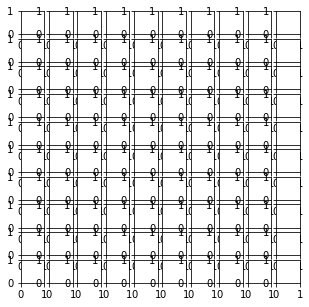

In [32]:
vis = features['res5'].detach().cpu().squeeze(0)

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(5, 5))
for i in range(100):
    axes[i].imshow(vis[i])
plt.show()

In [64]:
?backbone.forward

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
model.backbone.size_divisibility

32

In [25]:
transform_gen = T.ResizeShortestEdge(
            [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
        )

# whether the model expects BGR inputs or RGB
original_image = cv2.imread('data/samples/WechatIMG18.png')
original_image = original_image[:, :, ::-1]
image = transform_gen.get_transform(original_image).apply_image(original_image)
image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))[None, ...].to(device)
print(image.shape)

torch.Size([1, 3, 749, 1333])


In [46]:
with torch.no_grad():
    # whether the model expects BGR inputs or RGB
    original_image = cv2.imread('data/samples/WechatIMG18.png')
    original_image = original_image[:, :, ::-1]
    height, width = original_image.shape[:2]

    image = transform_gen.get_transform(original_image).apply_image(original_image)
    # Don't have to batch here
    image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1)).to(device)

    inputs = [{"image": image, "height": height, "width": width}]
    
    images = model.preprocess_image(inputs)
    print(images.tensor.shape)
    features = model.backbone(images.tensor)

torch.Size([1, 3, 768, 1344])


In [48]:
features.keys()

dict_keys(['p2', 'p3', 'p4', 'p5', 'p6'])

In [21]:
transform_gen = T.ResizeShortestEdge(
            [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
        )
with torch.no_grad(): 
    # whether the model expects BGR inputs or RGB
    original_image = cv2.imread('../phishpedia/benchmark/Sampled_phish1000/1&1 Ionos+2020-05-10-23`43`06/shot.png')
    original_image = original_image[:, :, ::-1]
    image = transform_gen.get_transform(original_image).apply_image(original_image)
    image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))[None, ...].to(device)
    print(image).shape
    feat_pred = model.backbone(image)
    

TypeError: 'NoneType' object is not subscriptable